# Functions to run likelihood tests of certain parameters

In [2]:
import socket as socket
import os as os
import sys as sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
socket_name = socket.gethostname()
print(socket_name)

if socket_name.startswith("compute-"):
    print("HSM O2 Computational partition detected.")
    path = "/n/groups/reich/hringbauer/git/hapBLOCK/"  # The Path on Harvard Cluster
else: 
    raise RuntimeWarning("Not compatible machine. Check!!")

os.chdir(path)  # Set the right Path (in line with Atom default)

print(os.getcwd())

sys.path.append("./python3/") 
from main import HMM_Full
from plot.plot_posterior import plot_posterior, plot_posterior_panel

compute-a-16-151.o2.rc.hms.harvard.edu
HSM O2 Computational partition detected.
/n/groups/reich/hringbauer/git/hapBLOCK


In [116]:
def plot_ll_curve(x, lls, color="maroon", lw=2, figsize=(4,4)):
    plt.figure(figsize=figsize)
    ax=plt.gca()
    ax.plot(jrts, lls,"o-", color=color, lw=lw)
    ax.set_xscale("linear")
    ax.set_xlabel("Jump Rate IBD state [per Morgan]")
    ax.set_ylabel("Log Likelihood")
    plt.show()
    
def run_ll_jrts(jrts, iid1="", iid2="", 
                ibd_in=1e4, ibd_out=1e-4, ch=3):
    """Get Log Likelihoods for jrts.
    jrts: Array
    return array of same size with log likelihoods"""
    h = HMM_Full(folder_in="./data/hdf5/1240k_v43/ch", l_model="hdf5", t_model="standard", 
                     e_model="haploid_gl", h_model = "FiveStateFast",
                     output=False, load=True)
    lls = np.zeros(len(jrts),dtype="float") # Create lls

    for i,jrt in enumerate(jrts):
        h.t_obj.set_params(ibd_in = ibd_in, ibd_out = ibd_out, ibd_jump = jrt)
        h.l_obj.set_params(iids=[iid1, iid2], ch=ch)
        _, _, _, _, tot_ll = h.run_fwd_bwd()
        lls[i] = tot_ll
    return lls

### Run Single LL Example

In [117]:
%%time
jrts = np.logspace(2, 3.5, num=30)
iid1, iid2 = "I3949.DG", "I3950.DG"

lls = run_ll_jrts(jrts, iid1=iid1, iid2=iid2, 
                  ch=3, ibd_in=1e4, ibd_out=1e-4)

CPU times: user 14.6 s, sys: 420 ms, total: 15 s
Wall time: 16.1 s


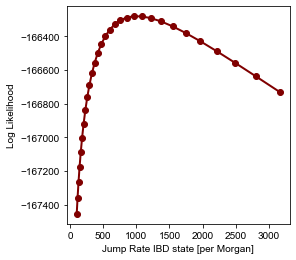

In [118]:
plot_ll_curve(jrts, lls)

# Load table of all parent offspring

In [44]:
df = pd.read_csv("./output/relatives_snp/po_full_all_ch.tsv", sep="\t")
df1 = df[df["relatedness"]=="Parent Offspring"].copy()

In [75]:
m_o_homo=0.0025
frac_snps_good=0.75
savepath="./output/relatives_snp/po_high_quality.tsv"

df = pd.read_csv("./output/relatives_snp/po_full_all_ch.tsv", sep="\t")
df1 = df[df["relatedness"]=="Parent Offspring"].copy()
df2 = df1[df1["max_opp_homo_ch"]<m_o_homo].copy()
df_po = df2[df2["frac_snps_good_ch3"]>frac_snps_good].copy()
#df3 = df2[df2["opp_homo_rate_ch3"]<m_o_homo].copy()
print(f"Loaded {len(df1)} PO relationships")
print(f"Filtered to {len(df2)} with max. o. hommo rate {m_o_homo}")
print(f"Filtered to {len(df_po)} with {frac_snps_good} good SNP frac")

df_po.to_csv(savepath, sep="\t")
print(f"Saved {len(df_po)} HQ Parent Offspring to {savepath}")

Loaded 333 PO relationships
Filtered to 305 with max. o. hommo rate 0.0025
Filtered to 220 with 0.75 good SNP frac
Saved 220 HQ Parent Offspring to ./output/relatives_snp/po_high_quality.tsv


### Minor Quality Check

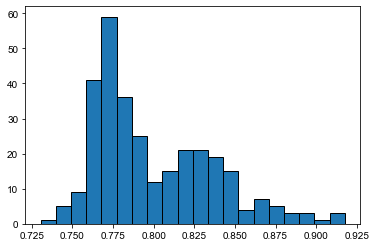

In [72]:
plt.figure()
ax=plt.gca()
ax.hist(df2["gt_match_rate_ch3"],ec="k", bins=20)
plt.show()

# Run single parent offspring [test]

In [95]:
%%time
jrts = np.logspace(2, 3.5, num=30)
iid1, iid2 = df_po["iid1"][0], df_po["iid2"][0]

lls = run_ll_jrts(jrts, iid1=iid1, iid2=iid2, 
                  ch=3, ibd_in=1e4, ibd_out=1e-4)

CPU times: user 14.1 s, sys: 419 ms, total: 14.5 s
Wall time: 16.4 s


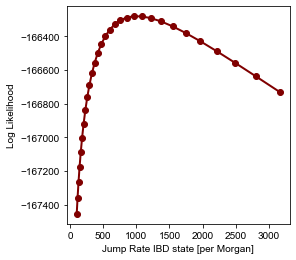

In [96]:
plot_ll_curve(jrts,lls)

In [ ]:
%%time
ch=3
jrts = np.logspace(2, 3.5, num=30)
lls_mat = np.zeros((len(df_po), len(jrts)))

for i in range(len(df_po[:])):
    print(f"Running Individual {i}")
    iid1, iid2 = df_po["iid1"][i], df_po["iid2"][i]
    lls = run_ll_jrts(jrts, iid1=iid1, iid2=iid2, 
                      ch=ch, ibd_in=1e4, ibd_out=1e-4)
    lls_mat[i] = lls

Running Individual 0
Running Individual 1
Running Individual 2


In [ ]:
### Save the Jump Rate LL Matrix
savepath="./output/jumprate_ll/ll_mat_po_hq.tsv"
np.savetxt(savepath,lls_mat, delimiter="\t")
print(f"Successfully saved {len(lls_mat)} Likelihood Curves to {savepath}")

In [122]:
l = np.loadtxt(savepath, delimiter="\t")

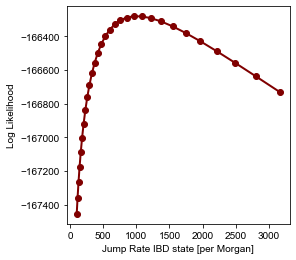

In [128]:
plot_ll_curve(jrts, l[0])

# Plot all parent offspring

In [129]:
len(df_po)

220